## Optimum delivery of masks in Paris
### TSP like problem
### Question: how should be structured the mask supply to have a minimum number of storage places and a minimum distance between storage and deliveries in Paris hospitals and care center

### Actions: 
- list of all hopitals and care center in Paris city  
   - we can then look at expanding to all Ile de France
- consolidation of weekly needs of each hospital with hypothesis (that can change)  
   - it is very hard to find the number of workersper places selected  
   - it is then very hard to define the need
- list of constraints:  
   - match the need everyweek (cneed cannot be defined)
   - minimum masks transport in Paris city from storage to needed place: minimum "loop distance" per cluster  
   - minimum storage places  
   - existing places are storage places  

In [1]:
import os
import numpy as np
import pandas as pd
import random

In [2]:
import scipy
from scipy.optimize import minimize
import math
from random import uniform

In [3]:
from math import sin, cos, sqrt, atan2, radians

### 1. get the Paris hospital list

https://www.data.gouv.fr/fr/datasets/les-etablissements-hospitaliers-franciliens-idf/

In [4]:
my_hospital_dataset=pd.read_csv(r'./raw_files/les_etablissements_hospitaliers_franciliens.csv',header=0, sep=';')

In [5]:
my_hospital_dataset.head(3)

,finess_et,finess_ej,raison_sociale,raison_sociale_entite_juridique,adresse_administrative_1,adresse_administrative_2,num_voie,cpt_num,type_voie,voie,...,num_siret,code_ape,code_tarif,lib_tarification,code_psph,participant_service_public_hospitalier,date_ouverture,lat,lng,wgs84
0,780809307,780002697,CENTRE MEDICO-PSY.78G01,CENTRE MEDICO-PSYCHOLOGIQUE ADULTES 78G01,NaN,NaN,8.0,NaN,R,MOZART,...,"2,67802E+13",8610Z,3,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,04/04/1904,48.998179,1.679343,"48.9981787,1.6793431"
1,780300125,780000535,POLYCLINIQUE REGION MANTAISE,POLYCLINIQUE DE LA REGION MANTAISE,NaN,NaN,23.0,NaN,BD,VICTOR DUHAMEL,...,"3,8306E+13",8610Z,7,ARS établissements de santé non financés dotat...,0.0,Non concerné,01/01/1935,48.984870,1.716842,"48.9848695,1.7168418"
2,780805644,780002697,CENTRE MOYEN SEJOUR B.GROS,CENTRE DE MOYEN SEJOUR BRIGITTE GROS,NaN,NaN,1.0,NaN,QUA,ALBERT PREMIER,...,"2,67806E+13",NaN,3,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,19/09/1985,49.003237,1.909192,"49.0032371,1.909192"


In [9]:
my_hospital_dataset.columns

Index(['finess_et', 'finess_ej', 'raison_sociale',
       'raison_sociale_entite_juridique', 'adresse_administrative_1',
       'adresse_administrative_2', 'num_voie', 'cpt_num', 'type_voie', 'voie',
       'adresse_complete', 'complement_adresse', 'num_dept', 'dept',
       'cp_ville', 'num_tel', 'num_fax', 'num_cat',
       'categorie_de_l_etablissement', 'num_type', 'type_etablissement',
       'num_siret', 'code_ape', 'code_tarif', 'lib_tarification', 'code_psph',
       'participant_service_public_hospitalier', 'date_ouverture', 'lat',
       'lng', 'wgs84'],
      dtype='object')

In [10]:
paris_hosp=my_hospital_dataset[my_hospital_dataset.num_dept==75]

In [11]:
paris_hosp.shape

(237, 31)

237 healthcare institutions are in paris, and are taken into account in the study

<function matplotlib.pyplot.show(*args, **kw)>

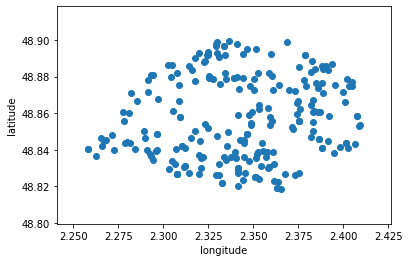

In [14]:
#let's plot them
import matplotlib.pyplot as plt

plt.scatter(paris_hosp.lng,paris_hosp.lat)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show

In [15]:
paris_hosp.groupby(by='type_etablissement').count().iloc[:,0]

type_etablissement
Autres Etablissements de Lutte contre les Maladies Mentales    109
Centres Hospitaliers                                             2
Centres Hospitaliers Régionaux                                  27
Centres Hospitaliers Spécialisés Lutte Maladies Mentales        41
Centres de Lutte contre le Cancer                                1
Etablissements de Soins de Courte Durée                         42
Etablissements de Soins de Longue Durée                          3
Etablissements de Soins de Suite et de Réadaptation             12
Name: finess_et, dtype: int64

there are 8 types of institutions listed:  
- 'Etablissements de Soins de Courte Durée',
- 'Autres Etablissements de Lutte contre les Maladies Mentales',
- 'Centres Hospitaliers Spécialisés Lutte Maladies Mentales',
- Etablissements de Soins de Suite et de Réadaptation',
- 'Centres Hospitaliers Régionaux',
- 'Etablissements de Soins de Longue Durée',
- 'Centres de Lutte contre le Cancer',
- 'Centres Hospitaliers'

### 2. set-up the functions for classical TSP problem solving in between Paris hospitals

In [16]:
#function1: build the node list array from the hospital dataset
def build_node_list(my_dataset):
    my_node_list=[]
    for i in range(my_dataset.shape[0]):
        my_node=[]
        my_node.append(np.array(my_dataset['lng'])[i])
        my_node.append(np.array(my_dataset['lat'])[i])
        my_node_list.append(my_node)
    return np.array(my_node_list)
    

In [17]:
#function2: build the Euclidian distance matrix in km
def build_dist_mat(my_nodelist):
    my_dim=my_nodelist.shape[0]
    my_mat=[]
    for i in range(my_dim):
        my_line=[]
        for j in range (my_dim):
            if i == j:
                my_dist=99999
                pass
            else:
                R = 6373.0

                lat1 = radians(my_nodelist[i][1])
                lon1 = radians(my_nodelist[i][0])
                lat2 = radians(my_nodelist[j][1])
                lon2 = radians(my_nodelist[j][0])

                dlon = lon2 - lon1
                dlat = lat2 - lat1

                a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
                c = 2 * atan2(sqrt(a), sqrt(1 - a))

                my_dist = R * c
                #my_dist=((my_nodelist[j][1]-my_nodelist[i][1])**2 + (my_nodelist[j][0]-my_nodelist[i][0])**2)**0.5
            my_line.append(my_dist)
        my_mat.append(my_line)
    return(np.array(my_mat)) #returns a np array of distance matrix

In [18]:
#function 3: find the shortest path algorithm
#step by step:
#1. pick a random start city A
#2. find the closest city B, and add the distance to total J+dist(A-B)
#3. remove the city A from the dist matrix and start again
# don't forget to add the distance from last city to first to the cost function

def my_best_travel(my_start_index,my_dist_mat):
    my_start=my_start_index
    my_mat=my_dist_mat
    my_N=my_mat.shape[0]
    my_cost=0
    my_best_solution=[]
    my_city_name=np.arange(1,my_N+1)
    my_best_solution.append(my_city_name[my_start])
    for my_index in range(my_N-1):
        my_cost+=my_mat[my_start].min()
        my_min_index=np.argmin(my_mat[my_start])
        my_best_solution.append(my_city_name[my_min_index])
        my_mat=np.delete(my_mat,my_start,axis=1)
        my_mat=np.delete(my_mat,my_start,axis=0)
        my_city_name=np.delete(my_city_name,my_start)
        if my_start<my_min_index:
            my_start=my_min_index-1
        else:
            my_start=my_min_index


    my_cost+=my_dist_mat[my_best_solution[0]-1][my_best_solution[-1]-1]
    return my_cost,np.array(my_best_solution)

In [19]:
#final function to loop over the start city
def my_best_sol(my_dist_mat):
    my_N=my_dist_mat.shape[0]
    my_best_cost=99999*my_N
    my_best_sol=[]
    for i in range(my_N):
        my_cost,my_solution=my_best_travel(i,my_dist_mat)
        if my_cost < my_best_cost:
            my_best_cost=my_cost
            my_best_sol=my_solution
    return my_best_cost,my_best_sol

In [20]:
#create a function to plot a node list based an order list
import matplotlib.pyplot as plt

def node_list_plot(my_node_list,my_solution):
    my_N=my_solution.shape[0]
    my_reord_nodelist=[]
    for i in range(my_N):
        my_reord_nodelist.append(my_node_list[my_solution[i]-1])
    A=pd.DataFrame(my_reord_nodelist, columns=['X','Y'])
    A['point_number']=np.array(my_solution)
    A=A.append(A.iloc[0,:])
    plt.plot(A['X'],A['Y'],'-o')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('optimum clustering of Paris Hospitals for minimum deliveries distances')

In [21]:
#then we need a cost function that computes cost based on a solution list and the matrix
# we will use a for loop
#works with indices not with city numbers

def cost_compute(my_solution, a_dist_mat):
    my_mat=a_dist_mat
    my_dim=my_mat.shape[0]
    my_cost=0
    for i in range(my_dim):
        A=0
        if i == my_dim-1:
            C=my_mat[my_solution[i]][my_solution[0]]
        else:
            C=my_mat[my_solution[i]][my_solution[i+1]]
        my_cost+=C
    return my_cost

In [110]:
# we also need a random solution modifier: 
# sol_modif1= swap 2 consecutive cities in the list
#works with index not city number
def sol_modif1(my_solution):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index = random.randrange(my_dim)
    if index==my_dim-1:
        my_sol_modif[0]=my_solution[index]
        my_sol_modif[index]=my_solution[0]
    else:   
        my_sol_modif[index]=my_solution[index+1]
        my_sol_modif[index+1]=my_solution[index]
    return np.array(my_sol_modif)

#sol_modif2 = reshuffle a portion of N consecutive cities in the list
def sol_modif2(my_solution, my_N_block=3):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index = random.randrange(my_dim-my_N_block)
    my_block=[my_solution[j] for j in range(index,index+my_N_block)]
    my_new_block=[]
    for i in range(my_N_block):
        my_dim2=my_N_block-i
        rand_index=int(random.randrange(my_dim2))
        A=my_block[rand_index]
        my_new_block.append(A)
        my_block.remove(A)
    for i in range(my_N_block):
        my_sol_modif[i+index]=my_new_block[i]  
    return np.array(my_sol_modif)

#sol_modif3 = exchange 2 random cities separated from a random distance
def sol_modif3(my_solution):
    my_dim=my_solution.shape[0]
    my_sol_modif=[i for i in my_solution]
    index1 = random.randrange(my_dim)
    index2 = random.randrange(my_dim)
    if index2 == index1:
        index2=index1 +1
    if index2==my_dim:
        index2=0 
    my_sol_modif[index1]=my_solution[index2]
    my_sol_modif[index2]=my_solution[index1]
    return np.array(my_sol_modif)

In [109]:
def simulated_annealing (cost_func, a_dist_mat, init_state, init_T, alpha, final_T, max_iter, modif_func):
    random.seed()
    count=1
    count2=1
    my_score=[]
    my_state =[]
    my_best_energy_plot=[]
    my_T=init_T
    current_state=init_state
    my_best_energy=cost_func(current_state,a_dist_mat)
    my_best_X=current_state
    while (my_T>final_T):
        new_state = modif_func(current_state)
        energy_delta= (cost_func(new_state,a_dist_mat)-cost_func(current_state,a_dist_mat))
        count2+=1
        if energy_delta < 0 :
            current_state = new_state
            my_energy=cost_func(new_state,a_dist_mat)
            if my_energy < my_best_energy:
                my_best_X=new_state
                my_best_energy=my_energy
                print(count,my_best_energy)
                count2=1
        else:
            proba = math.exp(-1*energy_delta/(my_T))
            my_rand_value=uniform(0,1)
            if my_rand_value>proba:
                current_state = new_state
        my_T=my_T*alpha
        count+=1
        
        if count>max_iter:
            break
        if count2>40000:
            break
        my_score.append(cost_func(current_state,a_dist_mat))
        my_state.append(current_state)
        my_best_energy_plot.append(my_best_energy)
        
    return my_best_X, count, my_score, my_best_energy, my_state,my_best_energy_plot

In [24]:
def solve_tsp_3(my_dataset,init_T, alpha, final_T, max_iter, my_N=10):
    my_cost=0
    my_sol=[]
    tsp_nodelist=build_node_list(my_dataset)
    my_dist_mat=build_dist_mat(tsp_nodelist)
    my_cost,my_sol=my_best_sol(my_dist_mat)
    #my_best_cost=my_cost
    #my_sol=sol_gen(tsp_nodelist)
    a_sol=my_sol-1 #array of index starts at 0
    my_best_X0=a_sol
    for i in range(my_N):
        print('epoch'+str(i))
        my_best_X1, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X0, init_T, alpha, final_T, max_iter, sol_modif3)
        my_best_X2, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X1, init_T, alpha, final_T, max_iter,sol_modif1)
        my_best_X3, count, my_score, my_best_energy, my_state,my_best_energy_plot=simulated_annealing(cost_compute,my_dist_mat,my_best_X2, init_T, alpha, final_T, max_iter,sol_modif2)
        my_best_X0=my_best_X3    
    my_final_sol=my_best_X1+1 #array of city number
    node_list_plot(tsp_nodelist,my_final_sol)
    my_best_cost=cost_compute(my_best_X3,my_dist_mat)
    return tsp_nodelist,my_best_cost,my_final_sol

epoch0
997 106.77026508496603
1004 106.68329792321886
3321 106.47577710129951
7644 106.36490139317314
8269 106.24323532598467
9621 106.19280457644938
11914 105.88499117465423
13737 105.81058380970053
14135 105.76765212809148
16354 105.61018958026733
17969 105.48025740668189
19624 105.3882511624712
20526 105.30369705223237
20916 105.2385307325789
24535 105.22325131880974
1876 105.14273918242894
3902 105.08210815164303
epoch1
epoch2
epoch3
epoch4
Wall time: 3min 6s


(array([[ 2.2809349, 48.8602135],
        [ 2.2906453, 48.8398738],
        [ 2.2968021, 48.8676646],
        [ 2.30717  , 48.8404815],
        [ 2.3089662, 48.8580522],
        [ 2.3250706, 48.8801161],
        [ 2.3400545, 48.8356021],
        [ 2.3412612, 48.8302646],
        [ 2.3489153, 48.8535813],
        [ 2.3506495, 48.824971 ],
        [ 2.35407  , 48.8311205],
        [ 2.3549532, 48.8435919],
        [ 2.358838 , 48.8305604],
        [ 2.3676796, 48.8265034],
        [ 2.3731388, 48.8262592],
        [ 2.3822703, 48.8885843],
        [ 2.3828579, 48.8670173],
        [ 2.3833511, 48.854938 ],
        [ 2.3834354, 48.8613915],
        [ 2.3916175, 48.8448201],
        [ 2.4091872, 48.8532632],
        [ 2.2777603, 48.8603562],
        [ 2.2782396, 48.8554944],
        [ 2.2821631, 48.8709172],
        [ 2.2897932, 48.8466393],
        [ 2.2913808, 48.8713798],
        [ 2.2915469, 48.878101 ],
        [ 2.2930475, 48.8806069],
        [ 2.2961015, 48.8394852],
        [ 2.29

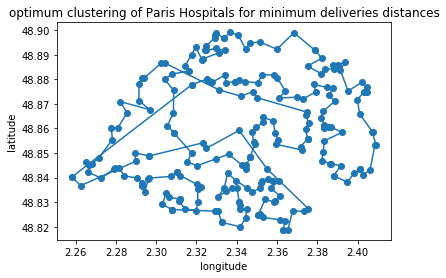

In [25]:
%%time
solve_tsp_3(paris_hosp,1E35, 0.999999999, 1, 1E7, my_N=5)

We have a 105km total distance to cover. Cannot be done every day or week in a one shot delivery.  
3 minutes computation

### 3. Transform the TSP problem into a logistic WAREHOUSE(s) and DELIVERIES problem  
We need to modify:  
- create a number of "hospitals clusters". What is the optimum number?
- the structure of the solution = the name of the logistic warehouses and the "local TSP" solutions. Where should be the local Warehouse? (all Warehouses should be easy to access from peripherique boulevard)
- the code of the constraints = limited number of warehouses, minimum distances of deliveries per day (multi TSP problem)  
- the optimisation of the whole

#### 3.1 apply a Kmeans to split the node list into nearest neighbours

In [29]:
from sklearn.cluster import KMeans
#returns a dataset wit the classes
def create_classes(my_dataset, my_N):
    my_node_list=build_node_list(my_dataset)
    my_kmean=KMeans(n_clusters=my_N, random_state=0)
    my_kmean.fit(my_node_list)
    my_classes = my_kmean.predict(my_node_list)
    my_centers=my_kmean.cluster_centers_
    my_final_data=pd.DataFrame(my_node_list)
    my_final_data['classes']=my_classes
    my_final_data.columns=['lng','lat','classes']

    return my_final_data,my_centers


#### 3.2 apply a TSP solver to each of the clusters created

In [107]:
def solve_tsp_clusters(my_node_list):
    my_best_cost=[]
    my_final_sol=[]
    for i in range(my_node_list.classes.max()+1):
        my_dataset=my_node_list[my_node_list.classes==i]
        _,my_best_cost_i,my_final_sol_i=solve_tsp_3(my_dataset,1E40, 0.999999999999, 1, 1E6, my_N=2)
        my_best_cost.append(my_best_cost_i)
        my_final_sol.append(my_final_sol_i)
    return my_best_cost,my_final_sol,sum(my_best_cost)

epoch0
2063 106.78332047770144
2285 106.62585792987728
2514 106.31804452808214
3817 106.11052370616278
8890 105.99964799803641
9720 105.93448167838294
15656 105.88405092884766
18226 105.8687715150785
19988 105.82583983346946
24786 105.57487211406624
27284 105.44493994048081
42176 105.31021848055691
44322 105.22325131880974
2418 105.14273918242894
3578 105.08210815164303
epoch1
epoch0
74 51.30992623454118
716 51.15096475934864
975 50.90832771773775
1259 50.85789696820245
2106 50.49454645953844
3156 50.33724974386829
3804 50.26652554843927
4414 50.25955666195136
5308 50.23454301418535
6247 49.72623054532334
8921 49.538392754778705
15428 49.46715509964006
21725 49.339621750222435
24281 48.87268446303106
32459 48.57870083177283
1618 48.545468781228514
epoch1
epoch0
1510 58.053926626069426
2071 57.63441861932525
2099 57.62740604362336
2229 57.612126629854224
4231 57.57855954694521
9048 57.47326538534467
12770 57.23716815291983
13314 57.227808823033776
15467 57.20516922293745
25330 57.130826

epoch1
epoch0
108 7.2472720419299135
epoch1
epoch0
epoch1
epoch0
3 7.119379950966875
epoch1
epoch0
99 8.178619508194654
247 8.162008445839612
330 7.963841012688374
epoch1
epoch0
55 9.867241389775078
epoch1
epoch0
128 9.0422700222068
epoch1
epoch0
7 8.011482746406452
epoch1
epoch0
256 7.5809780846832115
288 7.209199167959341
epoch1
epoch0
epoch1
epoch0
1 8.832501507169972
95 8.796990221675665
127 8.726146027493666
epoch1
epoch0
1 8.324472435507202
epoch1
epoch0
17 10.217584858222576
22 10.052682151913285
56 10.048573119609106
176 9.965763232090252
epoch1
epoch0
93 6.61581882526745
epoch1
epoch0
epoch1
epoch0
34 3.970918849659654
epoch1
epoch0
160 9.189896668356335
epoch1
epoch0
epoch1
epoch0
epoch1
epoch0
12 12.5451792077658
epoch1
epoch0
90 9.624251088138882
129 9.263815935914888
epoch1
epoch0
1 8.56563945172214
epoch1
epoch0
7 8.501615966394606
16 8.294959002654574
35 8.203716383112187
64 7.804500366541127
83 7.610505368018874
110 7.494673222690697
epoch1
epoch0
59 5.7857782763861385


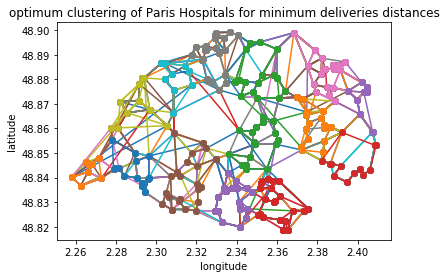

In [33]:
%%time
#we can now run a loop of the number of clusters and append the total road results to find the optimum

results=[]
for i in range(14):
    my_class_node_list,_=create_classes(paris_hosp,i+1)
    _,_,result=solve_tsp_clusters(my_class_node_list)
    results.append(result)

18 minutes computation

Text(0.5, 1.0, 'optimisation of number of clusters for minimum total distance')

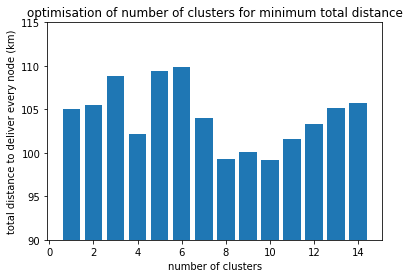

In [151]:
plt.bar(np.arange(1,15),results)
plt.xlabel('number of clusters')
plt.ylabel('total distance to deliver every node (km)')
plt.ylim(90,115)
plt.title('optimisation of number of clusters for minimum total distance')

minimum is for 8 or 10 clusters. We chose 8 clusters!  
Doing so we go from total 110km to less than 100km deliveries

#### 3.3: presentation of the optimum solution = 8 clusters

epoch0
7 12.598579501007844
202 12.589252644828804
326 12.5389710677231
549 12.430991439447304
epoch1
epoch0
105 14.262594151363686
1014 14.019957109752793
epoch1
epoch0
90 11.71110163334597
1053 11.684307012844906
1346 11.553571442102319
epoch1
epoch0
495 15.1027970380163
1874 15.0666500890282
5510 15.044010488931871
epoch1
epoch0
191 12.738111095599999
epoch1
epoch0
27 12.645615943440111
119 12.595185193904818
170 12.464806974534765
215 12.27188578279151
312 12.144352433373893
377 11.38343151492429
486 11.132877342290284
606 11.087103895432845
epoch1
epoch0
23 14.688171038790172
262 14.4777611122871
339 14.332202697404814
565 13.411210665630023
epoch1
epoch0
67 9.24765747972654
198 9.12477036098863
184 9.05747410591936
epoch1


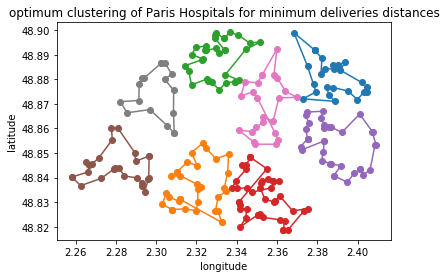

In [154]:
#we run the 8 clusters computation again
my_class_node_list,_=create_classes(paris_hosp,8)
clust_result,sol_result,result=solve_tsp_clusters(my_class_node_list)

In [155]:
#what is the total distance?
result

99.34243024281652

In [156]:
sol_result

[array([14, 15,  1, 16, 10, 13,  7, 17, 24, 18, 19, 25, 20,  2,  8,  4, 23,
         6, 11,  5, 12, 22, 21,  9,  3]),
 array([21, 30, 20,  3,  2, 34,  4, 24, 28,  5,  6, 12, 22, 32,  7, 15,  1,
        29, 19, 31, 11, 16, 25,  8, 18, 23, 33, 14, 27,  9, 17, 10, 13, 26]),
 array([16, 30,  2, 13, 11, 12, 27, 20, 31, 29, 18, 10, 26,  1, 14, 28, 32,
        24, 33, 34,  8, 19, 21,  5, 22, 17, 23,  9,  7,  3,  4, 25, 15,  6]),
 array([ 3, 36, 42, 31, 34, 44, 24, 40, 35,  8, 25,  7, 17, 16,  6, 21,  4,
        13, 14, 38, 32, 33, 43, 37, 39, 15, 18,  1, 26, 22, 10, 29, 23, 12,
        19, 20,  5,  2,  9, 27, 41, 11, 30, 28]),
 array([ 2,  8, 19, 20, 30,  4, 11, 31, 33, 12,  7, 34, 16, 17, 13,  5, 35,
        10,  9, 32, 25, 28, 15,  3, 14,  1, 22, 27, 24, 21,  6, 23, 29, 18,
        26]),
 array([14, 19, 20, 15,  2, 16, 25, 26,  6, 13,  7, 21,  5, 22,  1,  3,  4,
        18, 10, 12,  9, 23, 17, 11,  8, 24]),
 array([ 9, 13, 10, 14,  8,  4, 19, 12, 22,  6,  5, 16, 15, 20,  1, 23,  7,
        

99km is the total distance for 8 clusters!

Text(0.5, 1.0, 'Less than 15km to deliver all nodes in a cluster')

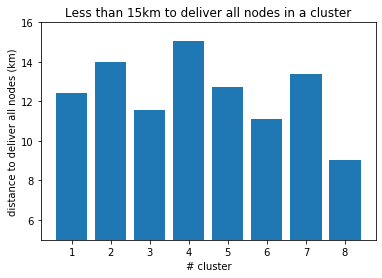

In [157]:
#how many kms to deliver everynode per cluster
plt.bar(np.arange(1,9),clust_result)
plt.xlabel('# cluster')
plt.ylabel('distance to deliver all nodes (km)')
plt.ylim(5,16)
plt.title('Less than 15km to deliver all nodes in a cluster')

In [158]:
my_class_node_list

,lng,lat,classes
0,2.280935,48.860214,5
1,2.290645,48.839874,5
2,2.296802,48.867665,7
3,2.307170,48.840482,1
4,2.308966,48.858052,7
...,...,...,...
232,2.393777,48.887097,0
233,2.394893,48.838081,4
234,2.401327,48.843498,4
235,2.404504,48.877042,0


In [51]:
! pip install gmplot

  Created wheel for gmplot: filename=gmplot-1.2.0-cp36-none-any.whl size=143770 sha256=cd7edc3794531cbff6ad1890ae36fbbf6aa5c5719092c21d10b2985780732026
  Stored in directory: C:\Users\jeanm\AppData\Local\pip\Cache\wheels\81\6a\76\4dd6a7cc310ba765894159ee84871e8cd55221d82ef14b81a1
Successfully built gmplot


In [59]:
!pip install folium

In [159]:
#plot on Paris Map
# import gmplot package 
import folium
col_list=['red', 'blue', 'green', 'purple', 'orange', 'darkred','pink','gray', 'beige', 'darkblue', 'lightred','darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']

mean_lat=my_class_node_list.lat.mean()
mean_lng=my_class_node_list.lng.mean()
my_map1 = folium.Map(location=[mean_lat, mean_lng], zoom_start=13,tiles='Stamen Toner')

for i in range(8):
    latitude_list = np.array(my_class_node_list[my_class_node_list.classes==i].lat)  
    longitude_list = np.array(my_class_node_list[my_class_node_list.classes==i].lng)
    points =[[latitude_list[j-1],longitude_list[j-1]] for j in sol_result[i]]
    points.append(points[0])
    #add markers
    for each in points:
        folium.CircleMarker(each,color=col_list[i],radius=8,fill=True).add_to(my_map1)
    #add lines
    folium.PolyLine(points, color=col_list[i], weight=8, opacity=1).add_to(my_map1)

In [162]:
my_map1

In [163]:
my_map1.save("./map1.html")

### 4. Open to all healthcare institutions of Ile de France  
How does the optimisation look like when we add all the health care institutions we know ?  
First, we only include institutions that are close to Paris

In [128]:
# let's select places at 15km of the center of paris
def distance_selec(my_dataset, my_dist):
    R = 6373.0
    my_array=[]
    my_dim=my_dataset.shape[0]
    my_data=my_dataset
    mean_lat=my_data.lat.mean()
    mean_lng=my_data.lng.mean()
    lat1 = radians(mean_lat)
    lon1 = radians(mean_lng)
    for i in range(my_dim):
        lat2 = radians(my_data.lat[i])
        lon2 = radians(my_data.lng[i])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        my_dist2 = R * c
        my_array.append(my_dist2)
    my_data['dist_to_center']=np.array(my_array)
    return my_data[my_data.dist_to_center<=my_dist]

In [139]:
my_close_hospital=distance_selec(my_hospital_dataset,10)

In [140]:
my_close_hospital.shape

(482, 32)

There are 482 hospitals institutions at 10km from the center of paris.  
Considering we have decided for 8 clusters with 237 hospitals, let's look at 16 clusters for 482 institutions.

epoch0
292 20.087065974057033
epoch1
epoch0
150 21.48632105790184
182 21.425263035458375
192 21.347074392263192
203 21.241013058518803
489 20.803759410399675
774 20.64847452579487
epoch1
epoch0
27 19.66035551447274
92 19.47628258962077
455 19.162795333386594
686 19.101910239152403
epoch1
epoch0
76 19.821725446335005
420 19.660421667134898
epoch1
epoch0
558 22.11945103150857
869 21.8865840075302
920 21.85609666464435
1203 21.786202677112538
1386 21.723387924921234
3077 21.715678587234276
3247 21.70969761594793
3564 21.645616226635696
4758 21.64393375293351
4974 21.622008289616105
245 21.591503513990666
epoch1
epoch0
145 18.398918099743575
2056 18.224433139885427
epoch1
epoch0
62 13.494112441637986
95 13.311069199052676
epoch1
epoch0
192 18.94283677885094
211 18.46360233573629
epoch1
epoch0
7 20.886726892930277
378 20.581353219409635
1098 20.467484052509054
1112 20.285332840891325
1881 20.219286131653067
1992 20.209866836692896
2216 19.974162628230722
3879 19.917268546049986
epoch1
epoch

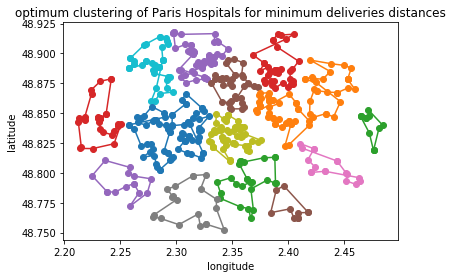

In [142]:
my_class_node_list,_=create_classes(my_close_hospital,16)
clust_result,sol_result,result=solve_tsp_clusters(my_class_node_list)

Text(0.5, 1.0, 'From 10 to 20km to deliver all nodes in a cluster')

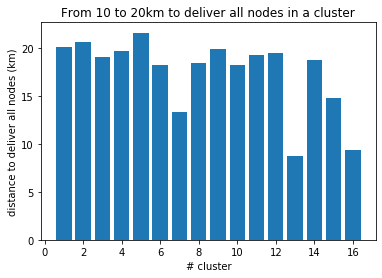

In [144]:
#how many kms to deliver everynode per cluster
plt.bar(np.arange(1,17),clust_result)
plt.xlabel('# cluster')
plt.ylabel('distance to deliver all nodes (km)')
#plt.ylim(5,16)
plt.title('From 10 to 20km to deliver all nodes in a cluster')

In [147]:
import folium
col_list=['red', 'blue', 'green', 'purple', 'orange', 'darkred','pink','gray', 'black', 'red', 'blue', 'green', 'purple', 'orange', 'darkred','pink','gray', 'black']

mean_lat=my_class_node_list.lat.mean()
mean_lng=my_class_node_list.lng.mean()
my_map = folium.Map(location=[mean_lat, mean_lng], zoom_start=13,tiles='Stamen Toner')

for i in range(16):
    point=[]
    latitude_list = np.array(my_class_node_list[my_class_node_list.classes==i].lat)  
    longitude_list = np.array(my_class_node_list[my_class_node_list.classes==i].lng)
    points =[[latitude_list[j-1],longitude_list[j-1]] for j in sol_result[i]]
    points.append(points[0])
    #add markers
    for each in points:
        folium.CircleMarker(each,color=col_list[i],radius=6,fill=True).add_to(my_map)
    #add lines
    folium.PolyLine(points, color=col_list[i], weight=6, opacity=1).add_to(my_map)

In [150]:
my_map

In [149]:
my_map.save("./my_map_sub.html")